# Violencia hacia la mujer en relación con el desasrrollo economico

Para el presente trabajo se utiliza informacion de "The Gender, Institutions and Development Database (GID-DB)" del año 2019 sobre violencia hacia la mujer, mas especificamente en lo correspondiente a integridad fisica restringida, y se contrasta con la informacion del World Economic Outlook Database del Fondo Monetario Internacional.

In [1]:
#Librerias necesarias

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


from pyod.models.mcd import MCD
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Primero se  trabaja con los datos de violencia hacia la mujer.

In [2]:
raw_1 = pd.read_csv('GIDDB2019_08122021180920621.csv')

In [3]:
raw_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   REGION      1245 non-null   object 
 1   LOCATION    1245 non-null   object 
 2   INC         1245 non-null   object 
 3   VAR         1245 non-null   object 
 4   TIME        1245 non-null   int64  
 5   Value       1245 non-null   float64
 6   Flag Codes  0 non-null      float64
dtypes: float64(2), int64(1), object(4)
memory usage: 68.2+ KB


In [4]:
#Se eliminan varibales vacias
raw_1 = raw_1.drop(['Flag Codes', 'TIME'], axis=1)

In [5]:
tab_1 = pd.pivot_table(raw_1,index=["REGION","LOCATION", "INC"],values=["Value"],
               columns=["VAR"])

In [6]:
tab_1.columns = tab_1.columns.get_level_values(1)

In [7]:
tab_1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 180 entries, ('AFR', 'AGO', 'LWI') to ('EUR', 'XKO', 'LWI')
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RPI_FGM_ATT    29 non-null     float64
 1   RPI_FGM_LAW    180 non-null    float64
 2   RPI_FGM_PRACT  29 non-null     float64
 3   RPI_MW_PRACT   178 non-null    float64
 4   RPI_RA_LAW     180 non-null    float64
 5   RPI_RA_PRACT   172 non-null    float64
 6   RPI_VAW_ATT    162 non-null    float64
 7   RPI_VAW_LAW    180 non-null    float64
 8   RPI_VAW_PRACT  135 non-null    float64
dtypes: float64(9)
memory usage: 15.0+ KB


In [8]:
tab_1.isnull().any()

VAR
RPI_FGM_ATT       True
RPI_FGM_LAW      False
RPI_FGM_PRACT     True
RPI_MW_PRACT      True
RPI_RA_LAW       False
RPI_RA_PRACT      True
RPI_VAW_ATT       True
RPI_VAW_LAW      False
RPI_VAW_PRACT     True
dtype: bool

Se toma el supuesto de que los valores faltantes son iguales a 0.

In [9]:
tab_1=tab_1.fillna(0)

In [10]:
tab_1.head()

VAR                  RPI_FGM_ATT  RPI_FGM_LAW  RPI_FGM_PRACT  RPI_MW_PRACT  \
REGION LOCATION INC                                                          
AFR    AGO      LWI          0.0         1.00            0.0         100.6   
       BDI      LOI          0.0         0.00            0.0         101.2   
       BEN      LOI          3.4         0.25            9.2         103.1   
       BFA      LOI          9.3         0.25           75.8         103.5   
       BWA      UMI          0.0         0.00            0.0         102.1   

VAR                  RPI_RA_LAW  RPI_RA_PRACT  RPI_VAW_ATT  RPI_VAW_LAW  \
REGION LOCATION INC                                                       
AFR    AGO      LWI        0.00          38.0         25.2         0.75   
       BDI      LOI        0.75          29.7         72.9         0.50   
       BEN      LOI        0.50          33.1         36.0         0.50   
       BFA      LOI        0.50          29.1         43.5         0.75   
       BWA      UMI        0.25           9.6          0.0         0.75   

VAR                  RPI_VAW_PRACT  
REGION LOCATION INC                 
AFR    AGO      LWI           34.8  
       BDI      LOI           46.7  
       BEN      LOI           68.6  
       BFA      LOI           11.5  
       BWA      UMI            0.0

Posteriormente se impoirta el archivo que contiene las caracterirsticas economicas de los paises.

In [11]:
raw_2 = pd.read_table('WEOOct2021all.xls')

In [12]:
raw_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   WEO Country Code               8822 non-null   object 
 1   ISO                            8820 non-null   object 
 2   WEO Subject Code               8820 non-null   object 
 3   Country                        8820 non-null   object 
 4   Subject Descriptor             8820 non-null   object 
 5   Subject Notes                  8624 non-null   object 
 6   Units                          8820 non-null   object 
 7   Scale                          3920 non-null   object 
 8   Country/Series-specific Notes  7634 non-null   object 
 9   1980                           3872 non-null   object 
 10  1981                           3992 non-null   object 
 11  1982                           4032 non-null   object 
 12  1983                           4074 non-null   o

Solo nos interesan los datos del 2019 por lo cual tomamos solamente dicha información.

In [13]:
raw_2['2019'] = raw_2['2019'].str.replace(',', '')

In [14]:
raw_2 = raw_2.replace('--', np.nan)

In [15]:
raw_2['2019']= raw_2['2019'].astype(float)

In [16]:
tab_2 = pd.pivot_table(raw_2,index=["ISO"],values=["2019"],
               columns=["WEO Subject Code"])

In [17]:
tab_2.columns = tab_2.columns.get_level_values(1)

In [18]:
tab_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, ABW to ZWE
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BCA           194 non-null    float64
 1   BCA_NGDPD     194 non-null    float64
 2   FLIBOR6       2 non-null      float64
 3   GGR           195 non-null    float64
 4   GGR_NGDP      195 non-null    float64
 5   GGSB          87 non-null     float64
 6   GGSB_NPGDP    83 non-null     float64
 7   GGX           194 non-null    float64
 8   GGXCNL        194 non-null    float64
 9   GGXCNL_NGDP   194 non-null    float64
 10  GGXONLB       186 non-null    float64
 11  GGXONLB_NGDP  186 non-null    float64
 12  GGXWDG        192 non-null    float64
 13  GGXWDG_NGDP   192 non-null    float64
 14  GGXWDN        89 non-null     float64
 15  GGXWDN_NGDP   89 non-null     float64
 16  GGX_NGDP      194 non-null    float64
 17  LE            39 non-null     float64
 18  LP            195 non-null    flo

Las variables economicas que se tienen en esta tabla son muy repetitivas e incluyen varias formas de medir lo mismo, por lo cual se descartan variables irrelevantes.


In [19]:
tab_2.drop(tab_2.columns[[0, 2, 3, 5,6, 7, 8, 9, 10, 11,12, 14,15, 17, 19, 20, 21, 22, 23, 24,25,27, 29, 33, 34, 35, 38, 39, 41, 43]], axis = 1, inplace = True)

In [20]:
tab_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, ABW to ZWE
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BCA_NGDPD    194 non-null    float64
 1   GGR_NGDP     195 non-null    float64
 2   GGXWDG_NGDP  192 non-null    float64
 3   GGX_NGDP     194 non-null    float64
 4   LP           195 non-null    float64
 5   NGDPRPPPPC   195 non-null    float64
 6   NGDP_FY      195 non-null    float64
 7   NGDP_RPCH    195 non-null    float64
 8   NGSD_NGDP    170 non-null    float64
 9   NID_NGDP     172 non-null    float64
 10  PCPIPCH      194 non-null    float64
 11  PPPEX        195 non-null    float64
 12  PPPSH        188 non-null    float64
 13  TM_RPCH      177 non-null    float64
 14  TX_RPCH      178 non-null    float64
dtypes: float64(15)
memory usage: 24.4+ KB


In [21]:
tab_2.isnull().any()

WEO Subject Code
BCA_NGDPD       True
GGR_NGDP       False
GGXWDG_NGDP     True
GGX_NGDP        True
LP             False
NGDPRPPPPC     False
NGDP_FY        False
NGDP_RPCH      False
NGSD_NGDP       True
NID_NGDP        True
PCPIPCH         True
PPPEX          False
PPPSH           True
TM_RPCH         True
TX_RPCH         True
dtype: bool

In [22]:
tab_2.head()

WEO Subject Code,BCA_NGDPD,GGR_NGDP,GGXWDG_NGDP,GGX_NGDP,LP,NGDPRPPPPC,NGDP_FY,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPIPCH,PPPEX,PPPSH,TM_RPCH,TX_RPCH
ISO,,,,,,,,,,,,,,,
ABW,2.507,23.961,72.885,23.621,0.112,36219.60,5.925,-2.100,21.387,NaN,3.938,1.399,0.003,NaN,NaN
AFG,11.705,26.941,6.130,27.999,32.200,2439.68,1469.600,3.912,29.897,18.192,2.302,17.950,0.061,-7.473,-3.838
AGO,6.079,21.179,113.554,20.403,30.128,7043.65,30833.450,-0.535,26.923,20.844,17.079,139.415,0.164,-11.380,-5.925
ALB,-7.628,27.414,67.792,29.373,2.881,13881.23,1679.250,2.174,14.879,22.790,1.438,40.291,0.031,4.716,1.675
AND,18.010,38.016,35.399,35.594,0.078,56331.79,2.818,2.017,NaN,NaN,0.742,0.619,0.003,NaN,NaN


Ya se cuenta con los 2 dataframes ya en el formato deseado se procede a juntarlos por medio de inner join para poder tener un panel balanceado de datos.

In [23]:
tab_1.reset_index( inplace=True)
tab_2.reset_index( inplace=True)

df = pd.merge(left=tab_1, right=tab_2, left_on='LOCATION', right_on='ISO', how='inner')

In [24]:
df.head()

,REGION,LOCATION,INC,RPI_FGM_ATT,RPI_FGM_LAW,RPI_FGM_PRACT,RPI_MW_PRACT,RPI_RA_LAW,RPI_RA_PRACT,RPI_VAW_ATT,...,NGDPRPPPPC,NGDP_FY,NGDP_RPCH,NGSD_NGDP,NID_NGDP,PCPIPCH,PPPEX,PPPSH,TM_RPCH,TX_RPCH
0,AFR,AGO,LWI,0.0,1.00,0.0,100.6,0.00,38.0,25.2,...,7043.650,30833.450,-0.535,26.923,20.844,17.079,139.415,0.164,-11.380,-5.925
1,AFR,BDI,LOI,0.0,0.00,0.0,101.2,0.75,29.7,72.9,...,751.762,5559.590,1.842,7.724,19.286,-0.709,615.481,0.007,45.588,-15.813
2,AFR,BEN,LOI,3.4,0.25,9.2,103.1,0.50,33.1,36.0,...,3283.840,8432.250,6.866,21.596,25.630,-0.933,208.557,0.030,-8.378,-12.058
3,AFR,BFA,LOI,9.3,0.25,75.8,103.5,0.50,29.1,43.5,...,2178.320,9369.190,5.699,23.383,26.659,-3.233,203.083,0.034,-2.652,-0.052
4,AFR,BWA,UMI,0.0,0.00,0.0,102.1,0.25,9.6,0.0,...,16386.870,176.998,2.993,23.155,29.833,2.745,4.547,0.029,11.939,-7.091


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 175
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   REGION         176 non-null    object 
 1   LOCATION       176 non-null    object 
 2   INC            176 non-null    object 
 3   RPI_FGM_ATT    176 non-null    float64
 4   RPI_FGM_LAW    176 non-null    float64
 5   RPI_FGM_PRACT  176 non-null    float64
 6   RPI_MW_PRACT   176 non-null    float64
 7   RPI_RA_LAW     176 non-null    float64
 8   RPI_RA_PRACT   176 non-null    float64
 9   RPI_VAW_ATT    176 non-null    float64
 10  RPI_VAW_LAW    176 non-null    float64
 11  RPI_VAW_PRACT  176 non-null    float64
 12  ISO            176 non-null    object 
 13  BCA_NGDPD      176 non-null    float64
 14  GGR_NGDP       176 non-null    float64
 15  GGXWDG_NGDP    174 non-null    float64
 16  GGX_NGDP       175 non-null    float64
 17  LP             176 non-null    float64
 18  NGDPRPPPPC

In [26]:
df[['ISO', 'LOCATION', 'REGION', 'INC']]

,ISO,LOCATION,REGION,INC
0,AGO,AGO,AFR,LWI
1,BDI,BDI,AFR,LOI
2,BEN,BEN,AFR,LOI
3,BFA,BFA,AFR,LOI
4,BWA,BWA,AFR,UMI
...,...,...,...,...
171,SRB,SRB,EUR,UMI
172,SVK,SVK,EUR,HIN
173,SVN,SVN,EUR,HIN
174,SWE,SWE,EUR,HIN


In [27]:
df = df.drop(['ISO'], axis=1)

Se codifican las variables categoricas

In [28]:
df['Region_encode']=LabelEncoder().fit_transform(df.REGION)

In [29]:
df['Loc_encode']=LabelEncoder().fit_transform(df.LOCATION)
Location_dir =df[['Loc_encode', 'LOCATION']]
Location_dir

,Loc_encode,LOCATION
0,1,AGO
1,10,BDI
2,12,BEN
3,13,BFA
4,26,BWA
...,...,...
171,145,SRB
172,148,SVK
173,149,SVN
174,150,SWE


In [30]:
pd.set_option('display.max_rows', Location_dir.shape[0]+1)
Location_dir

,Loc_encode,LOCATION
0,1,AGO
1,10,BDI
2,12,BEN
3,13,BFA
4,26,BWA
5,27,CAF
6,32,CIV
7,33,CMR
8,34,COD
9,35,COG


In [31]:
df['INC'].unique()

array(['LWI', 'LOI', 'UMI', 'HIN'], dtype=object)

In [32]:
inc_dir = {'LOI': 1,
           'LWI': 2,
           'UMI': 3,
           'HIN': 4}
df['Inc_ordinal'] = df.INC.map(inc_dir)

In [33]:
df.drop(['LOCATION','REGION' ,'INC'],axis=1, inplace=True)

In [34]:
df.head()

,RPI_FGM_ATT,RPI_FGM_LAW,RPI_FGM_PRACT,RPI_MW_PRACT,RPI_RA_LAW,RPI_RA_PRACT,RPI_VAW_ATT,RPI_VAW_LAW,RPI_VAW_PRACT,BCA_NGDPD,...,NGSD_NGDP,NID_NGDP,PCPIPCH,PPPEX,PPPSH,TM_RPCH,TX_RPCH,Region_encode,Loc_encode,Inc_ordinal
0,0.0,1.00,0.0,100.6,0.00,38.0,25.2,0.75,34.8,6.079,...,26.923,20.844,17.079,139.415,0.164,-11.380,-5.925,0,1,2
1,0.0,0.00,0.0,101.2,0.75,29.7,72.9,0.50,46.7,-11.562,...,7.724,19.286,-0.709,615.481,0.007,45.588,-15.813,0,10,1
2,3.4,0.25,9.2,103.1,0.50,33.1,36.0,0.50,68.6,-4.034,...,21.596,25.630,-0.933,208.557,0.030,-8.378,-12.058,0,12,1
3,9.3,0.25,75.8,103.5,0.50,29.1,43.5,0.75,11.5,-3.276,...,23.383,26.659,-3.233,203.083,0.034,-2.652,-0.052,0,13,1
4,0.0,0.00,0.0,102.1,0.25,9.6,0.0,0.75,0.0,-8.419,...,23.155,29.833,2.745,4.547,0.029,11.939,-7.091,0,26,3


Para trabajar con un dataframe completo nos deshacemos de las observaciones que no contienen la informacion completa

In [35]:
df = df.dropna()

In [36]:
df.isnull().any()

RPI_FGM_ATT      False
RPI_FGM_LAW      False
RPI_FGM_PRACT    False
RPI_MW_PRACT     False
RPI_RA_LAW       False
RPI_RA_PRACT     False
RPI_VAW_ATT      False
RPI_VAW_LAW      False
RPI_VAW_PRACT    False
BCA_NGDPD        False
GGR_NGDP         False
GGXWDG_NGDP      False
GGX_NGDP         False
LP               False
NGDPRPPPPC       False
NGDP_FY          False
NGDP_RPCH        False
NGSD_NGDP        False
NID_NGDP         False
PCPIPCH          False
PPPEX            False
PPPSH            False
TM_RPCH          False
TX_RPCH          False
Region_encode    False
Loc_encode       False
Inc_ordinal      False
dtype: bool

In [37]:
df.head()

,RPI_FGM_ATT,RPI_FGM_LAW,RPI_FGM_PRACT,RPI_MW_PRACT,RPI_RA_LAW,RPI_RA_PRACT,RPI_VAW_ATT,RPI_VAW_LAW,RPI_VAW_PRACT,BCA_NGDPD,...,NGSD_NGDP,NID_NGDP,PCPIPCH,PPPEX,PPPSH,TM_RPCH,TX_RPCH,Region_encode,Loc_encode,Inc_ordinal
0,0.0,1.00,0.0,100.6,0.00,38.0,25.2,0.75,34.8,6.079,...,26.923,20.844,17.079,139.415,0.164,-11.380,-5.925,0,1,2
1,0.0,0.00,0.0,101.2,0.75,29.7,72.9,0.50,46.7,-11.562,...,7.724,19.286,-0.709,615.481,0.007,45.588,-15.813,0,10,1
2,3.4,0.25,9.2,103.1,0.50,33.1,36.0,0.50,68.6,-4.034,...,21.596,25.630,-0.933,208.557,0.030,-8.378,-12.058,0,12,1
3,9.3,0.25,75.8,103.5,0.50,29.1,43.5,0.75,11.5,-3.276,...,23.383,26.659,-3.233,203.083,0.034,-2.652,-0.052,0,13,1
4,0.0,0.00,0.0,102.1,0.25,9.6,0.0,0.75,0.0,-8.419,...,23.155,29.833,2.745,4.547,0.029,11.939,-7.091,0,26,3


In [38]:
df.describe()

,RPI_FGM_ATT,RPI_FGM_LAW,RPI_FGM_PRACT,RPI_MW_PRACT,RPI_RA_LAW,RPI_RA_PRACT,RPI_VAW_ATT,RPI_VAW_LAW,RPI_VAW_PRACT,BCA_NGDPD,...,NGSD_NGDP,NID_NGDP,PCPIPCH,PPPEX,PPPSH,TM_RPCH,TX_RPCH,Region_encode,Loc_encode,Inc_ordinal
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,...,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,3.871795,0.764423,6.878205,103.963462,0.399038,15.349359,23.977564,0.591346,22.689744,-2.836218,...,20.963532,23.829160,3.574090,403.815083,0.631090,2.519846,2.904205,1.448718,83.121795,2.743590
std,12.852181,0.360600,20.850671,8.727687,0.352158,8.800216,22.378335,0.204952,18.678686,8.687813,...,11.312379,8.355234,6.221819,1993.800050,2.022956,9.625628,8.080301,1.165609,50.506383,1.100568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,-54.439000,...,-41.039000,4.033000,-16.365000,0.187000,0.001000,-21.107000,-21.874000,0.000000,0.000000,1.000000
25%,0.000000,0.437500,0.000000,102.975000,0.000000,9.000000,5.275000,0.500000,9.700000,-5.491250,...,14.599750,18.556000,0.969500,1.307000,0.025000,-1.951750,-1.488250,0.000000,39.750000,2.000000
50%,0.000000,1.000000,0.000000,104.700000,0.500000,12.900000,16.600000,0.750000,20.850000,-2.220500,...,21.291000,22.591500,2.246500,9.043500,0.093500,1.894000,1.910000,2.000000,80.500000,3.000000
75%,0.000000,1.000000,0.000000,105.700000,0.750000,20.325000,39.375000,0.750000,31.400000,1.465000,...,28.118250,26.463500,4.107500,141.341750,0.418500,6.156750,7.350250,2.000000,125.250000,4.000000
max,75.200000,1.000000,96.800000,115.800000,1.000000,39.100000,92.100000,1.000000,85.000000,16.854000,...,45.026000,60.058000,53.548000,22802.840000,17.312000,45.588000,37.542000,3.000000,174.000000,4.000000


### Analisis Exploratorio de Datos

In [39]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [40]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Deteccion de outiers

Para detección de anomalías se utiliza el metodo 'Minimum Covariance Determinant'

In [41]:
def Outlier(df, contamination):
    
    
    try:
        clf_name = 'MCD'
        clf = MCD(contamination=contamination)
        clf.fit(df)

        y_train_pred = clf.labels_  
        y_train_scores = clf.decision_scores_  
        
        y_test_pred = clf.predict(df)  
        y_test_scores = clf.decision_function(df) 

        count = 0
        for i in y_test_pred:
            count += i
            
        count, y_test_pred
    except Exception as e:
        print(e) 
    
    return y_test_pred

In [42]:
Outlier_Det = Outlier(df,contamination=0.05)
y_outlier = pd.Series(Outlier_Det, index = np.arange(len(Outlier_Det)), name = 'Outlier_Det')
df_out = pd.concat([df, y_outlier], axis = 1)
df_out.head()

C:\Users\pollo\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (50.499444237356570 > 49.200248768218671). You may want to try with a higher value of support_fraction (current value: 0.590).
  warnings.warn("Determinant has increased; this should not happen: "
C:\Users\pollo\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (79.404774138836913 > 48.677080264532620). You may want to try with a higher value of support_fraction (current value: 0.590).
  warnings.warn("Determinant has increased; this should not happen: "


,RPI_FGM_ATT,RPI_FGM_LAW,RPI_FGM_PRACT,RPI_MW_PRACT,RPI_RA_LAW,RPI_RA_PRACT,RPI_VAW_ATT,RPI_VAW_LAW,RPI_VAW_PRACT,BCA_NGDPD,...,NID_NGDP,PCPIPCH,PPPEX,PPPSH,TM_RPCH,TX_RPCH,Region_encode,Loc_encode,Inc_ordinal,Outlier_Det
0,0.0,1.00,0.0,100.6,0.00,38.0,25.2,0.75,34.8,6.079,...,20.844,17.079,139.415,0.164,-11.380,-5.925,0.0,1.0,2.0,0.0
1,0.0,0.00,0.0,101.2,0.75,29.7,72.9,0.50,46.7,-11.562,...,19.286,-0.709,615.481,0.007,45.588,-15.813,0.0,10.0,1.0,0.0
2,3.4,0.25,9.2,103.1,0.50,33.1,36.0,0.50,68.6,-4.034,...,25.630,-0.933,208.557,0.030,-8.378,-12.058,0.0,12.0,1.0,0.0
3,9.3,0.25,75.8,103.5,0.50,29.1,43.5,0.75,11.5,-3.276,...,26.659,-3.233,203.083,0.034,-2.652,-0.052,0.0,13.0,1.0,0.0
4,0.0,0.00,0.0,102.1,0.25,9.6,0.0,0.75,0.0,-8.419,...,29.833,2.745,4.547,0.029,11.939,-7.091,0.0,26.0,3.0,0.0


In [43]:
df_out.query('Outlier_Det == 1')

,RPI_FGM_ATT,RPI_FGM_LAW,RPI_FGM_PRACT,RPI_MW_PRACT,RPI_RA_LAW,RPI_RA_PRACT,RPI_VAW_ATT,RPI_VAW_LAW,RPI_VAW_PRACT,BCA_NGDPD,...,NID_NGDP,PCPIPCH,PPPEX,PPPSH,TM_RPCH,TX_RPCH,Region_encode,Loc_encode,Inc_ordinal,Outlier_Det
15,12.2,0.75,83.0,104.3,0.50,27.4,51.4,0.75,0.0,12.066,...,4.033,-16.365,4.655,0.005,3.701,-14.142,0.0,50.0,1.0,1.0
57,0.0,1.00,0.0,102.6,0.75,22.2,5.2,0.75,0.0,-9.314,...,17.766,0.186,1.344,0.002,0.299,2.116,1.0,20.0,3.0,1.0
59,0.0,1.00,0.0,104.7,0.50,10.8,8.5,0.25,33.5,-3.463,...,15.403,3.733,2.281,2.407,5.288,-1.579,1.0,22.0,3.0,1.0
88,0.0,1.00,0.0,115.2,0.00,15.4,28.0,0.75,13.5,9.061,...,20.308,2.712,0.543,0.112,-0.979,2.388,2.0,9.0,3.0,1.0
89,0.0,1.00,0.0,104.4,0.75,12.0,28.3,0.75,53.3,-1.687,...,31.570,5.475,31.408,0.644,4.370,13.988,2.0,14.0,2.0,1.0
90,0.0,1.00,0.0,105.7,0.00,12.0,0.0,0.75,0.0,-2.065,...,33.084,1.006,0.187,0.057,-5.568,0.381,2.0,16.0,4.0,1.0
97,0.0,1.00,0.0,108.1,0.25,7.0,26.0,0.75,9.4,5.883,...,18.193,2.883,6.101,0.346,-7.265,-6.141,2.0,69.0,4.0,1.0
116,0.0,1.00,0.0,106.9,0.75,18.0,41.5,0.75,0.0,3.497,...,21.044,0.663,1.599,0.701,-1.944,-0.812,2.0,115.0,3.0,1.0


Si bien se lograron identificar outliers en el dataframe, es importante incluir estos datso en el analisis puesto que es de interes ver las caracterirsticas de estos paises en cuention economica y de violencia hacia la mujer, lo por cual se opta por dejarlos en el analisis.


### Analisís de Componentes Principales

shape of X_pca (156, 17)
[0.21941701 0.11267963 0.07773807 0.07033449 0.06151329 0.05673086
 0.05174237 0.04311027 0.03811262 0.03396323 0.03165058 0.03069986
 0.02767871 0.02667452 0.02060422 0.02008478 0.01539339]
suma: 0.9227345116259855


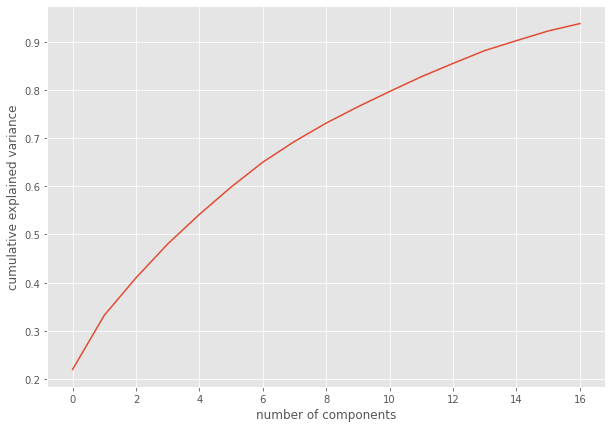

In [44]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
plt.style.use('ggplot')

#Se elimina la variable dependiente y se normalizan los datos
scaler=StandardScaler()
df.drop(['Region_encode'], axis=1)
scaler.fit(df)
X_scaled=scaler.transform(df)
 
pca=PCA(n_components=26)
pca=PCA(.93)
pca.fit(X_scaled)
X_pca=pca.transform(X_scaled)
 
print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:16]))


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


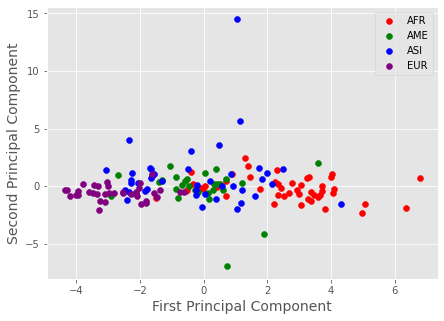

In [45]:

#graficamos en 2 Dimensiones
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=df['Region_encode'].values
cdict={0:'red',1:'green', 2:'blue', 3:'purple'}
labl={0:'AFR',1:'AME', 2:'ASI', 3:'EUR'}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],label=labl[l])
 
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

In [46]:
df_fin = pd.merge(left=df, right=Location_dir, on='Loc_encode')

In [47]:
inc_dir_2 = {1:'LOI',
            2:'LWI',
            3: 'UMI',
            4:'HIN'}
df_fin['Income'] = df_fin.Inc_ordinal.map(inc_dir_2)

In [48]:
reg_dir = {0:'AFR',
            1:'AME',
            2:'ASI',
            3:'EUR'}
df_fin['Region'] = df_fin.Region_encode.map(reg_dir)

In [49]:
df_fin.head()

,RPI_FGM_ATT,RPI_FGM_LAW,RPI_FGM_PRACT,RPI_MW_PRACT,RPI_RA_LAW,RPI_RA_PRACT,RPI_VAW_ATT,RPI_VAW_LAW,RPI_VAW_PRACT,BCA_NGDPD,...,PPPEX,PPPSH,TM_RPCH,TX_RPCH,Region_encode,Loc_encode,Inc_ordinal,LOCATION,Income,Region
0,0.0,1.00,0.0,100.6,0.00,38.0,25.2,0.75,34.8,6.079,...,139.415,0.164,-11.380,-5.925,0,1,2,AGO,LWI,AFR
1,0.0,0.00,0.0,101.2,0.75,29.7,72.9,0.50,46.7,-11.562,...,615.481,0.007,45.588,-15.813,0,10,1,BDI,LOI,AFR
2,3.4,0.25,9.2,103.1,0.50,33.1,36.0,0.50,68.6,-4.034,...,208.557,0.030,-8.378,-12.058,0,12,1,BEN,LOI,AFR
3,9.3,0.25,75.8,103.5,0.50,29.1,43.5,0.75,11.5,-3.276,...,203.083,0.034,-2.652,-0.052,0,13,1,BFA,LOI,AFR
4,0.0,0.00,0.0,102.1,0.25,9.6,0.0,0.75,0.0,-8.419,...,4.547,0.029,11.939,-7.091,0,26,3,BWA,UMI,AFR


In [50]:
df_fin.to_csv('women_violence_eco.csv')